In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns

# Pulling data from database to check that it was stored correctly and also to start analyzing it

In [2]:
conn = psycopg2.connect("host=localhost dbname=rancher port=5430")

In [3]:
def db_table_exists(conn, tablename):
    # thanks to Peter Hansen's answer for this sql
    sql = f"""SELECT * FROM information_schema.tables
            WHERE table_name='{tablename}'"""
    
    # return results of sql query from conn as a pandas dataframe
    results_df = pd.read_sql_query(sql, conn)
    
    # True if we got any results back, False if we didn't
    return bool(len(results_df))

In [4]:
# Instantiate a new cursor object
cur = conn.cursor()

# Use cursor object to create a database for storing the information we scraped and cleaned, if one doesn't already exist.
cur.execute("""    
    CREATE TABLE IF NOT EXISTS us_census_regions(
    state text PRIMARY KEY,
    state_code text,
    us_region text,
    us_division text
    )
""")

# Copy data from our CSV file into database.  
### Note, we can use the ; separator freely because we replaced all instances of semicolons in post_text to commas during the preprocessing stage, ensuring that psycopg2 won't misinterpret a semicolon in the body of a post as a separator.
### Also, we must specify null="" because Python represents null values as an empty string when writing to a CSV file and psycopg2 needs to know how null values are represented in the CSV file in order to properly insert null values into the database
if not db_table_exists(conn, 'us_census_regions'):
    with open('../census-regions/us_census_regions.csv', 'r') as file:
        next(file) # Skip the header row
        cur.copy_from(file, 'us_census_regions', null="", sep=',')
    
# Commit changes to database
conn.commit()

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_sql = pd.read_sql_query("""SELECT cl.*, cr.us_region, cr.us_division
                              FROM cl_tutoring AS cl
                              LEFT JOIN us_census_regions as cr
                                ON cl.state = cr.state
                              WHERE date_scraped = '2022-02-03'""", con=conn)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
df_sql.tail()

,id,date_scraped,price,city,subregion,region,state,post_text,date_posted,us_region,us_division
357,1024,2022-02-03,40.0,Portland-Seattle,Seattle,seattle,Washington,\n\n\n\n\nNote: I'm actually based in Portland...,2022-01-22 05:13:48,West,Pacific
358,1025,2022-02-03,45.0,Olympia,Olympia,seattle,Washington,\n\n\n\n\nHow can I help you?\n\nI have decade...,2022-01-19 13:39:09,West,Pacific
359,1026,2022-02-03,45.0,Online,no subregion found,skagit,Washington,\n\n\n\n\nI love math! I taught my two childre...,2022-01-17 13:29:06,West,Pacific
360,1027,2022-02-03,25.0,Evansville,no subregion found,madison,Wisconsin,"\n\n\n\n\nHighschool math teacher, 38 years. T...",2022-01-17 16:55:14,Midwest,East North Central
361,1028,2022-02-03,45.0,no city found,no subregion found,madison,Wisconsin,\n\n\n\n\nHi! My name is Michelle and I am an ...,2022-01-14 15:21:43,Midwest,East North Central


In [7]:
state_counts = df_sql['state'].value_counts().rename('state_counts')

state_counts_df = df_sql.merge(state_counts.to_frame(),
                               left_on='state',
                               right_index=True)

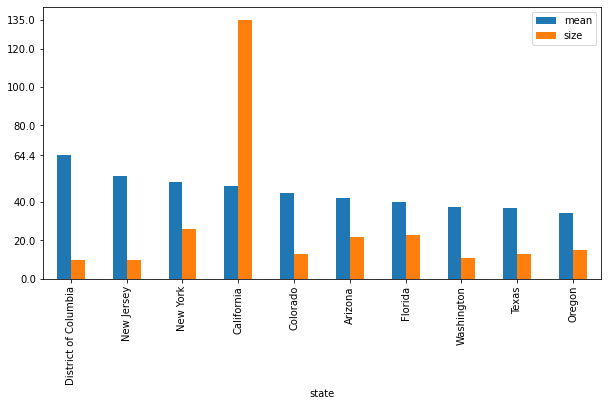

In [10]:
st_cnt_greater_10 = state_counts_df['state_counts']>=10
st_avg_greater_10 = state_counts_df[st_cnt_greater_10].groupby('state')['price'].agg(['mean', 'size'])

fig, ax = plt.subplots(1,1,figsize=(10,5))
#state_counts_df[st_cnt_greater_10]['state'].value_counts().plot(kind='bar', ax=ax);

st_avg_greater_10.sort_values(by='mean', ascending=False).plot(kind='bar', ax=ax)
ax.set_yticks([0, 20, 40, st_avg_greater_10['mean'].max(), 80, 100, 120, st_avg_greater_10['size'].max()]);

In [11]:
st_cnt_less_10 = state_counts_df['state_counts']<10
st_avg_less_10 = state_counts_df[st_cnt_less_10]['price'].agg(['mean', 'size'])

In [12]:
st_avg_greater_10

,mean,size
state,,
Arizona,42.285714,22
California,48.209677,135
Colorado,44.541667,13
District of Columbia,64.375000,10
Florida,40.090909,23
New Jersey,53.611111,10
New York,50.369565,26
Oregon,34.500000,15
Texas,36.666667,13


In [13]:
region_counts = df_sql['region'].value_counts().rename('region_counts')

region_counts_df = df_sql.merge(region_counts.to_frame(),
                               left_on='region',
                               right_index=True)

<AxesSubplot:>

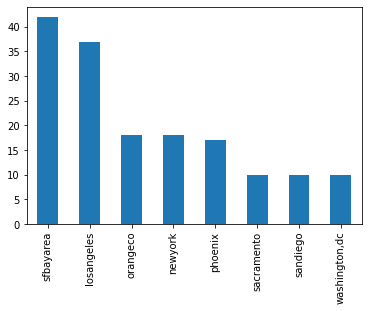

In [14]:
region_counts_df[region_counts_df['region_counts']>=10]['region'].value_counts().plot(kind='bar')

In [15]:
df_sql.head()

,id,date_scraped,price,city,subregion,region,state,post_text,date_posted,us_region,us_division
0,866,2022-02-03,35.0,no city found,no subregion found,orlando,Florida,"\n\n\n\n\nI tutor algebra, geometry, trigonome...",2022-01-09 15:15:33,South,South Atlantic
1,867,2022-02-03,40.0,Orlando And Surrounding Areas,no subregion found,orlando,Florida,\n\n\n\n\nHello! I have a bachelors degree in ...,2022-01-06 19:13:09,South,South Atlantic
2,868,2022-02-03,40.0,Sarasota,no subregion found,sarasota,Florida,"""\n\n\n\n\nAdvanced HS and College Math Tutor ...",2022-01-30 19:22:56,South,South Atlantic
3,869,2022-02-03,15.0,Tallahassee,no subregion found,tallahassee,Florida,\n\n\n\n\nI have 5 years of experience tutorin...,2022-01-15 06:19:12,South,South Atlantic
4,912,2022-02-03,75.0,Savage,Dakota/Scott,minneapolis,Minnesota,"\n\n\n\n\nI own a test prep company, Prep 720....",2022-01-21 16:37:50,Midwest,West North Central


In [16]:
state_list_greater_10 = st_avg_greater_10.index.to_list()

def state_grouper_by_count(df, ind, col):
    state = df[col].loc[ind]
    if df[col].loc[ind] in state_list_greater_10:
        return state 
    else:
        return 'Other'
    
states_grpby_count = df_sql.groupby(lambda x: state_grouper_by_count(df_sql, x, 'state'))

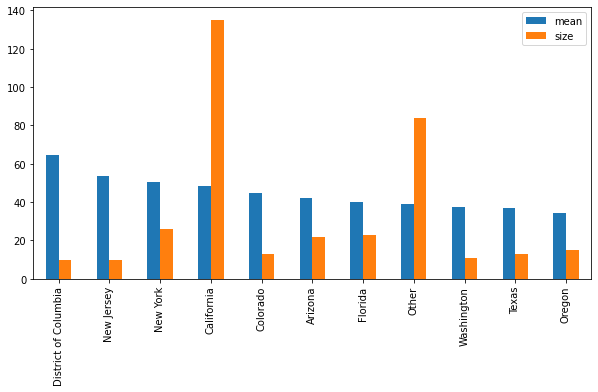

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
states_grpby_count['price'].agg(['mean', 'size']).sort_values(by='mean', ascending=False).plot.bar(ax=ax);

In [18]:
states_grpby_count = df_sql.groupby(lambda x: state_grouper_by_count(df_sql, x, 'state'))

In [19]:
df_sql.groupby('us_region')['price'].agg(['mean', 'size'])

,mean,size
us_region,,
Midwest,38.181159,24
Northeast,48.981481,50
South,40.931818,71
West,45.013201,217


In [20]:
df_sql.groupby('us_division')['price'].agg(['mean', 'size'])

,mean,size
us_division,,
East North Central,34.510417,17
East South Central,49.166667,3
Middle Atlantic,49.402778,40
Mountain,41.819728,52
New England,47.296296,10
Pacific,46.035948,165
South Atlantic,42.585106,51
West North Central,46.571429,7
West South Central,34.531250,17


In [21]:
df_sql['region'].value_counts()

sfbayarea     42
losangeles    37
orangeco      18
newyork       18
phoenix       17
              ..
ventura        1
stockton       1
charlotte      1
greensboro     1
baltimore      1
Name: region, Length: 100, dtype: int64

In [22]:
df_sql['subregion'].value_counts()

no subregion found      173
San Francisco            13
Westside-Southbay        12
East Bay                 12
Central La               10
Manhattan                 9
South Bay                 7
Central/South Phx         7
East Valley               6
City Of San Diego         6
Northern Virginia         6
Long Beach                5
San Gabriel Valley        5
Hillsborough Co           4
Hennepin Co               4
Queens                    4
Peninsula                 4
North Sd County           4
Seattle                   4
Sf Valley                 4
Multnomah Co              4
Oahu                      3
North Bay                 3
Santa Cruz                3
Eastside                  3
Broward County            3
Phx North                 3
Dallas                    2
Boston/Camb/Brook         2
Long Island               2
City Of Chicago           2
District Of Columbia      2
Atlanta                   2
Clark/Cowlitz             2
Pinellas Co               2
Clackamas Co        

In [23]:
df_sql['price'].mean()

44.27529761904762

In [24]:
df_sql['price'].median()

40.0

In [25]:
df_sql.groupby(by='region')['price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
region,,
centralnj,90.000000,2
boise,70.000000,2
memphis,70.000000,1
boston,65.433333,5
"washington,dc",64.375000,8
...,...,...
buffalo,NaN,0
"columbus,oh",NaN,0
jerseyshore,NaN,0


In [26]:
df_sql[(df_sql['region']=='los_angeles') & (df_sql['price'] > 60)]['price']

Series([], Name: price, dtype: float64)

In [ ]:
df_sql[df_sql['region']=='los_angeles'].boxplot(column='price')
plt.scatter(df_sql[df_sql['region']=='los_angeles']['price'])

In [ ]:
sns.boxplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'])
sns.swarmplot(x='region', y='price', data=df_sql[df_sql['region']=='los_angeles'], color='r');